# Investigate a Dataset - Titanic Data

## What factors made people more likely to survive?

In [1]:
# from scripts import titanic

import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import json

class titanic_analysis(object):
    def __init__(self):
        self.titanic_data_file = './data/titanic_data.csv' 
        self.titanic_data = pd.read_csv(self.titanic_data_file, header = False)
        self.titanic_data_cleaned = self.data_wrangling()              
    def data_wrangling(self):
        df = self.titanic_data.drop('Cabin', 1)[~self.titanic_data.Embarked.isnull()]
        df['Salutation'] = df.apply(lambda x: self.get_salutation(x['Name']), axis=1)
        med = df.groupby('Salutation')['Age'].transform('median')
        df['Age'] = df['Age'].fillna(med)
        return df
    def get_salutation(self, name):
        m = re.search(r'Miss\.|Mr\.|Mrs\.|Master\.|Rev\.|Dr\.', name)
        if m:
            salutation = m.group()
        else:
            salutation = 'other'
        return salutation
    def draw_pie_chart(self, gpby_col, filter_value):
        df = self.titanic_data.groupby([gpby_col, 'Survived'])[['Survived']].count()
        slices = df.iloc[df.index.get_level_values(gpby_col) == filter_value].Survived.tolist()
        activities = [0, 1]
        cols = ['r', 'g']
        plt.pie(slices, labels = activities, colors = cols, shadow = True, autopct = "%1.1f%%")
        plt.title(gpby_col + '=' + str(filter_value))
        plt.legend(('Not Survived','Survived'))
        plt.show()
        
    def get_treemap(self, x, y):
        df_count = self.titanic_data.groupby([x, y])[[y]].count()
        df_survival_rate = self.titanic_data.groupby([x, y, 'Survived'])[['Survived']].count()
        result = [['Location', 'Parent', 'Numbers of Passenger(size)', 'Survival Rate(color)'], [x + '&' + y, None, 0, 0]]
        for i in df_count.index.levels[0]:
            for j in df_count.index.levels[1]:      
                df_count_filter = df_count.iloc[df_count.index.get_level_values(df_count.index.names[0]) == i]
                df_count_filter = df_count_filter.iloc[df_count_filter.index.get_level_values(df_count.index.names[1]) == j]
                if df_count_filter[y].tolist():
                    df_survival_rate_filter = \
                    df_survival_rate.iloc[df_survival_rate.index.get_level_values(df_count.index.names[0]) == i]
                    df_survival_rate_filter =  \
                    df_survival_rate_filter.iloc[df_survival_rate_filter.index.get_level_values(df_count.index.names[1]) == j]
                    if df_survival_rate_filter.Survived.tolist():
                        df_survival_rate_filter = \
                        df_survival_rate_filter.iloc[df_survival_rate_filter.index.get_level_values('Survived') == 1]
                        if df_survival_rate_filter.Survived.tolist():
                            n_survived = df_survival_rate_filter.Survived.tolist()[0]
                        else:
                            n_survived = 0
                    result.append([df_count.index.names[0] + '=' + str(i) + '&' + df_count.index.names[1] + '=' + str(j),
                           df_count.index.names[0] + '&' + df_count.index.names[1],
                          int(df_count_filter[y].tolist()[0]), 
                           float(int(n_survived))/float(int(df_count_filter[y].tolist()[0]))])
     
        return json.dumps(result)    
# titanic_obj = titanic.titanic_analysis()
titanic_obj = titanic_analysis()

### Titanic Data

Contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on [the Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.

### Numerical Analysis

* The overall survival rate is just 38%, but for woman is 74%, so 性別可能是影響存活與否的一個重要因素

In [3]:
N = titanic_obj.titanic_data.shape[0] #sample size
print 'overall survival rate is ' + str(float(titanic_obj.titanic_data.Survived.sum())/N)
N_female = titanic_obj.titanic_data[titanic_obj.titanic_data.Sex == 'female'].shape[0]
print 'survival rate for woman is ' + \
        str(float(titanic_obj.titanic_data[titanic_obj.titanic_data.Sex == 'female'].Survived.sum())/N_female)

overall survival rate is 0.383838383838
survival rate for woman is 0.742038216561


* `Cabin` 有太多缺失值, 我們選擇忽略這個變數, 因為他不能提供太多的訊息
* `Embarked` 缺失值只有兩筆, 直接忽略這兩筆資料並不會對分析結果有太多影響
* 我認為 `Age` 可能會是影響存活率的關鍵因素之一, 所以這邊必須對缺失值進行處理, 詳細處理過程後面會在描述 

In [4]:
titanic_obj.titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Data Visualization

* 如同 Numerical Analysis 的結果, 透過圖形能更明顯看出性別對存活率的影響

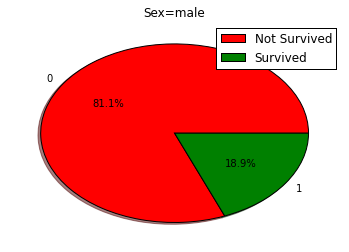

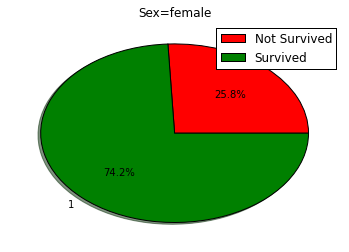

In [5]:
%matplotlib inline 
titanic_obj.draw_pie_chart('Sex', 'male')
titanic_obj.draw_pie_chart('Sex', 'female')

* 接著, 我們針對性別再做更進一步的二維 treemap 圖形, 其中區塊代表資料比數, 顏色深淺代表存活比例

* 由下面 method 整理出 data for treemap

In [11]:
titanic_obj.get_treemap('Sex', 'Pclass')

'[["Location", "Parent", "Numbers of Passenger(size)", "Survival Rate(color)"], ["Sex&Pclass", null, 0, 0], ["", "Sex&Pclass", 0, 0], ["", "Sex&Pclass", 0, 1], ["Sex=female&Pclass=1", "Sex&Pclass", 94, 0.9680851063829787], ["Sex=female&Pclass=2", "Sex&Pclass", 76, 0.9210526315789473], ["Sex=female&Pclass=3", "Sex&Pclass", 144, 0.5], ["Sex=male&Pclass=1", "Sex&Pclass", 122, 0.36885245901639346], ["Sex=male&Pclass=2", "Sex&Pclass", 108, 0.1574074074074074], ["Sex=male&Pclass=3", "Sex&Pclass", 347, 0.13544668587896252]]'

* 雖然女性存活率比男性高, 不過在 Pclass = 3 的女性就沒有這麼幸運了

![img1](https://raw.githubusercontent.com/ShaneKao/Titanic-Data/master/Analyzing_the_NYC_Subway_Dataset/image/pclass3_female.png)

In [30]:
survival_pclass3_female = titanic_obj.titanic_data[titanic_obj.titanic_data.Sex=='female'] \
                                                [titanic_obj.titanic_data.Pclass==3].Survived.tolist()
'survival rate for pclass = 3 and female is ' + str(float(sum(survival_pclass3_female))/float(len(survival_pclass3_female)))

'survival rate for pclass = 3 and female is 0.5'

### Data Wrangling

* 刪除變數 `Cabin` & 刪除 `Embarked` 缺失的資料 (souce code line ?)

* 我們可以從姓名中的稱謂來預測年齡, 首先先將稱謂抽取出來, 由下圖可以看出 Master. 年齡偏低, 且 Mrs. 比 Miss. 年齡高, 因此, 利用稱謂預測年齡 maybe a good idea

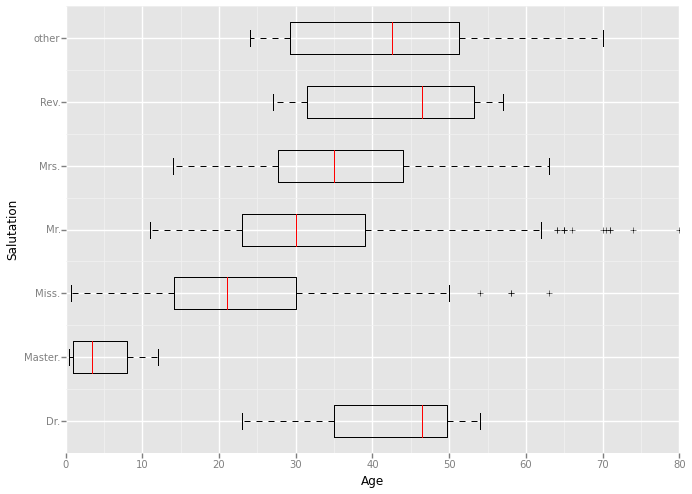

<ggplot: (34546369)>

In [4]:
df = titanic_obj.titanic_data
df['Salutation'] = df.apply(lambda x: titanic_obj.get_salutation(x['Name']), axis=1)
ggplot(df, aes(x='Age', y='Salutation')) + geom_boxplot()

* 我們用相同稱謂年齡的中位數來對年齡的缺失值進行插值

* show data ready for analysis

In [44]:
titanic_obj.titanic_data_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Mr.
5,6,0,3,"Moran, Mr. James",male,30,0,0,330877,8.4583,Q,Mr.
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,S,Mr.
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,S,Master.
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,S,Mrs.
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,C,Mrs.


### Data Analysis

#### Apriori

利用 Apriori 找出包含存活變數的頻繁集

* 考慮變數 `Survived`, `Pclass`, `Sex`, `SibSp`, `Parch`, `Embarked`, `Salutation`

In [11]:
df = titanic_obj.titanic_data_cleaned
df = df.iloc[:,[1, 2, 4, 6, 7, 10, 11]]

* set minsup to 0.4 

In [12]:
from scripts.apriori import apriori
df.Survived = df.Survived.apply(lambda x: 'Survived = ' + str(x))
df.Pclass = df.Pclass.apply(lambda x: 'Pclass = ' + str(x))
df.Sex = df.Sex.apply(lambda x: 'Sex = ' + str(x))
df.SibSp = df.SibSp.apply(lambda x: 'SibSp = ' + str(x))
df.Parch = df.Parch.apply(lambda x: 'Parch = ' + str(x))
df.Embarked = df.Embarked.apply(lambda x: 'Embarked = ' + str(x))
df.Salutation = df.Salutation.apply(lambda x: 'Salutation = ' + str(x))
F = apriori(df.values.tolist(), 0.4)

{'Salutation = Master.': 40, 'Salutation = Mrs.': 124, 'Survived = 0': 549, 'Sex = female': 312, 'Pclass = 3': 491, 'Pclass = 2': 184, 'Pclass = 1': 214, 'Salutation = Rev.': 6, 'Salutation = other': 14, 'Salutation = Dr.': 7, 'SibSp = 3': 16, 'SibSp = 2': 28, 'SibSp = 1': 209, 'SibSp = 0': 606, 'Embarked = C': 168, 'SibSp = 5': 5, 'SibSp = 4': 18, 'SibSp = 8': 7, 'Embarked = S': 644, 'Survived = 1': 340, 'Embarked = Q': 77, 'Sex = male': 577, 'Parch = 4': 4, 'Parch = 5': 5, 'Parch = 6': 1, 'Parch = 0': 676, 'Parch = 1': 118, 'Parch = 2': 80, 'Parch = 3': 5, 'Salutation = Mr.': 517, 'Salutation = Miss.': 181}


* 包含存活變數的頻繁集

In [13]:
for i in F:
    if 'Survived = 0' in i or 'Survived = 1' in i:
        print i

['Survived = 0']
['Embarked = S', 'Survived = 0']
['Parch = 0', 'Survived = 0']
['Pclass = 3', 'Survived = 0']
['Salutation = Mr.', 'Survived = 0']
['Sex = male', 'Survived = 0']
['SibSp = 0', 'Survived = 0']
['Embarked = S', 'Sex = male', 'Survived = 0']
['Parch = 0', 'Salutation = Mr.', 'Survived = 0']
['Parch = 0', 'Salutation = Mr.', 'Sex = male', 'Survived = 0']
['Parch = 0', 'Sex = male', 'Survived = 0']
['Parch = 0', 'SibSp = 0', 'Survived = 0']
['Salutation = Mr.', 'Sex = male', 'Survived = 0']
['Sex = male', 'SibSp = 0', 'Survived = 0']
['Parch = 0', 'Salutation = Mr.', 'Sex = male', 'Survived = 0']


* Sex = male 頻繁的出現, 這樣的結果與前面視覺化的結果一致, 另外 Parch = 0, 'Embarked = S', 'Pclass = 3'存活率也較低

* 結果並沒有任何包含 Survived = 1的頻繁集, 這是因為普遍的存活率偏低(about 38%), 如果把 minsup 調小, 又會讓結果太亂, 行程太多頻繁集, 不易讀

#### CART